Name: Joshua Payapulli
<br>
Github Username: Payapulli

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from IPython.display import Image

Get the AReM Data Set

In [2]:
# Data Cleaning: we know that cycling/dataset9.csv and cycling/dataset14.csv has 
# trailing commas that need to be stripped
# bending2/dataset4.csv needs to be changed from using spaces as the delimeter to commas so it is standardized
folders_to_clean = ['../data/AReM/cycling/dataset9.csv', '../data/AReM/cycling/dataset14.csv', '../data/AReM/bending2/dataset4.csv']

for folder in folders_to_clean:
    with open(folder, 'r') as file:
        lines = file.readlines()

    if 'bending2' in folder:
        # Do not remove spaces from the first 4 lines
        headers = lines[:4]
        # standardize delimeter to comma
        headers.extend([','.join(line.split()) + '\n' for line in lines[4:]])
    else:
        # remove trailing commas, skip first 4 rows again
        cleaned_lines = [line.rstrip(',\n') + '\n' for line in lines]

    # Rewrite file with cleaned data
    with open(folder, 'w') as file:
        file.writelines(cleaned_lines)

In [3]:
df = []
instance = 1
# loop through each folder in AReM Data Set
for folder in os.listdir('../data/AReM/'):
    folder_path = os.path.join('../data/AReM/', folder)
    
    # loop through the files in each folder
    if os.path.isdir(folder_path):
        
        # For the bending1 and bending2 folders we only want the first two
        # datasets in test
        if 'bending1' in folder or 'bending2' in folder:
            test_datasets = ['dataset1.csv', 'dataset2.csv']
        else:
            test_datasets = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # check we have a csv file
            if os.path.isfile(file_path) and file_path.endswith('.csv'):
                try:
                    curr_df = pd.read_csv(file_path, skiprows=4)
                    
                    # Assign the 'test' or 'train' label based on the file name
                    curr_df['data_split'] = 'test' if file in test_datasets else 'train'
                    curr_df['instance'] = instance
                    folder = file_path.split("AReM/")[1]
                    curr_df['folder'] = folder
                    instance += 1
                    df.append(curr_df)
                except pd.errors.ParserError as e:
                    print(f"Error parsing {file_path}. Error: {e}")

# convert into pandas DataFrame
df = pd.concat(df, ignore_index=True)
df

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      42.00       0.00      18.50       0.50      12.00   
1                  250      42.00       0.00      18.00       0.00      11.33   
2                  500      42.75       0.43      16.75       1.79      18.25   
3                  750      42.50       0.50      16.75       0.83      19.00   
4                 1000      43.00       0.82      16.25       0.83      18.00   
...                ...        ...        ...        ...        ...        ...   
42234           118750      41.75       1.79      11.00       6.00      16.67   
42235           119000      36.33       0.47      16.00       3.16      20.33   
42236           119250      31.50       1.50      21.00       0.00      12.25   
42237           119500      34.25       6.38      12.67       2.49      15.25   
42238           119750      38.33       0.94      15.25       2.17      20.33   

       var_rss23 data_split  instance                 folder  
0           0.00      train         1  bending1/dataset7.csv  
1           0.94      train         1  bending1/dataset7.csv  
2           0.43      train         1  bending1/dataset7.csv  
3           1.22      train         1  bending1/dataset7.csv  
4           0.00      train         1  bending1/dataset7.csv  
...          ...        ...       ...                    ...  
42234       2.49      train        88   cycling/dataset9.csv  
42235       1.70      train        88   cycling/dataset9.csv  
42236       7.12      train        88   cycling/dataset9.csv  
42237       4.21      train        88   cycling/dataset9.csv  
42238       1.25      train        88   cycling/dataset9.csv  

[42239 rows x 10 columns]

### (b) Splitting Data

In [4]:
# display training data
train_df = df[df['data_split'] == 'train']
print("Train Data")
# skip labels for instance and test split as these are not important now
train_df.iloc[:, :7]

Train Data


# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      42.00       0.00      18.50       0.50      12.00   
1                  250      42.00       0.00      18.00       0.00      11.33   
2                  500      42.75       0.43      16.75       1.79      18.25   
3                  750      42.50       0.50      16.75       0.83      19.00   
4                 1000      43.00       0.82      16.25       0.83      18.00   
...                ...        ...        ...        ...        ...        ...   
42234           118750      41.75       1.79      11.00       6.00      16.67   
42235           119000      36.33       0.47      16.00       3.16      20.33   
42236           119250      31.50       1.50      21.00       0.00      12.25   
42237           119500      34.25       6.38      12.67       2.49      15.25   
42238           119750      38.33       0.94      15.25       2.17      20.33   

       var_rss23  
0           0.00  
1           0.94  
2           0.43  
3           1.22  
4           0.00  
...          ...  
42234       2.49  
42235       1.70  
42236       7.12  
42237       4.21  
42238       1.25  

[33119 rows x 7 columns]

In [5]:
# Display test data
test_df = df[df['data_split'] == 'test']
print("Test Data")
# skip labels for instance and test split as these are not important now
test_df.iloc[:, :7]

Test Data


# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
1920                 0      39.25       0.43      22.75       0.43      33.75   
1921               250      39.25       0.43      23.00       0.00      33.00   
1922               500      39.25       0.43      23.25       0.43      33.00   
1923               750      39.50       0.50      23.00       0.71      33.00   
1924              1000      39.50       0.50      24.00       0.00      33.00   
...                ...        ...        ...        ...        ...        ...   
38394           118750      36.50       1.50      15.67       9.74      20.50   
38395           119000      36.00       0.00      23.25       1.30      17.00   
38396           119250      32.33       5.56      15.33       3.77      14.50   
38397           119500      32.00       5.87      12.25       2.17      14.50   
38398           119750      38.00       2.12      16.50       3.20      11.25   

       var_rss23  
1920        1.30  
1921        0.00  
1922        0.00  
1923        0.00  
1924        0.00  
...          ...  
38394       2.87  
38395       1.63  
38396       4.82  
38397       2.87  
38398       5.80  

[9120 rows x 7 columns]

### (c) Feature Extraction

In [6]:
def extract_features(df):
    features = []
    for instance, group in df.groupby('instance'):
        instance_features = {'instance': instance}
        time_series = 1
        for col in group.columns:
            if col not in ['# Columns: time', 'instance', 'data_split', 'folder']:
                temp_series = group[col]
                instance_features[f'min_{time_series}'] = temp_series.min()
                instance_features[f'max_{time_series}'] = temp_series.max()
                instance_features[f'mean_{time_series}'] = temp_series.mean()
                instance_features[f'median_{time_series}'] = temp_series.median()
                instance_features[f'std_{time_series}'] = temp_series.std()
                instance_features[f'1st_quart_{time_series}'] = temp_series.quantile(0.25)
                instance_features[f'3rd_quart_{time_series}'] = temp_series.quantile(0.75)
                time_series += 1
        features.append(instance_features)
    features_df = pd.DataFrame(features)
    return features_df


features_df = extract_features(df)
# skip first col as this is repeated
features_df.iloc[:, 1:]

min_1  max_1     mean_1  median_1     std_1  1st_quart_1  3rd_quart_1  \
0   36.25  48.00  43.969125     44.50  1.618364      43.3100        44.67   
1   37.00  48.00  43.454958     43.25  1.386098      42.5000        45.00   
2   33.00  47.75  42.179812     43.50  3.670666      39.1500        45.00   
3   33.00  45.75  41.678063     41.75  2.243490      41.3300        42.75   
4   37.25  45.00  40.624792     40.50  1.476967      39.2500        42.00   
..    ...    ...        ...       ...       ...          ...          ...   
83  18.50  44.25  35.752354     36.00  4.614802      33.0000        39.33   
84  24.25  45.00  37.177042     36.25  3.581301      34.5000        40.25   
85  23.33  43.50  36.244083     36.75  3.822016      33.4575        39.25   
86  26.25  44.25  36.957458     36.29  3.434863      34.5000        40.25   
87  27.75  44.67  37.144833     36.33  3.758904      34.0000        40.50   

    min_2  max_2    mean_2  ...     std_5  1st_quart_5  3rd_quart_5  min_6  \
0     0.0   1.50  0.413125  ...  3.318301      20.5000      23.7500    0.0   
1     0.0   1.58  0.378083  ...  2.488862      22.2500      24.0000    0.0   
2     0.0   3.00  0.696042  ...  3.849448      30.4575      36.3300    0.0   
3     0.0   2.83  0.535979  ...  2.411026      28.4575      31.2500    0.0   
4     0.0   1.30  0.358604  ...  2.188449      33.0000      36.0000    0.0   
..    ...    ...       ...  ...       ...          ...          ...    ...   
83    0.0  12.60  3.328104  ...  3.120057      14.0000      18.0625    0.0   
84    0.0   8.58  2.374208  ...  2.890347      17.9500      21.7500    0.0   
85    0.0   9.71  2.736021  ...  3.617702      15.7500      21.0000    0.0   
86    0.0   8.64  2.420083  ...  2.851673      14.0000      18.2500    0.0   
87    0.0  10.76  2.419062  ...  2.689291      15.0000      18.7500    0.0   

    max_6    mean_6  median_6     std_6  1st_quart_6  3rd_quart_6  
0    2.96  0.555312     0.490  0.487826       0.0000       0.8300  
1    5.26  0.679646     0.500  0.622534       0.4300       0.8700  
2    2.18  0.613521     0.500  0.524317       0.0000       1.0000  
3    1.79  0.383292     0.430  0.389164       0.0000       0.5000  
4    1.92  0.570583     0.430  0.582915       0.0000       1.3000  
..    ...       ...       ...       ...          ...          ...  
83   9.39  3.069667     2.770  1.748326       1.7975       4.0600  
84   9.34  2.921729     2.500  1.852600       1.5000       3.9000  
85  11.15  3.530500     3.110  1.963685       2.1700       4.6175  
86   8.34  2.934625     2.525  1.631380       1.6600       4.0300  
87   8.75  2.822437     2.590  1.637183       1.5800       3.7400  

[88 rows x 42 columns]

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [7]:
# get cols for features mean, max, 3rd quartile and time series 1, 2, 6. 
selected_cols = [feature + '_' + i for feature in ['mean', 'max', '3rd_quart'] for i in ['1', '2', '6']]
# get instances that corresponding to bending folders
bending_instances = set(df[df['folder'].str.contains('bending')]['instance'])

# bending_features is features_df for selected features, time series with binary
# label to tell us if it comes from class bending
train_features = extract_features(train_df)
bending_features = train_features[selected_cols].copy()
bending_features['isBending'] = train_features['instance'].apply(lambda x: 1 if x in bending_instances else 0)
bending_features

mean_1    mean_2    mean_6  max_1  max_2  max_6  3rd_quart_1  \
0   43.969125  0.413125  0.555312  48.00   1.50   2.96        44.67   
1   43.454958  0.378083  0.679646  48.00   1.58   5.26        45.00   
2   42.179812  0.696042  0.613521  47.75   3.00   2.18        45.00   
3   41.678063  0.535979  0.383292  45.75   2.83   1.79        42.75   
4   43.954500  0.426250  0.493292  47.40   1.70   1.79        45.00   
..        ...       ...       ...    ...    ...    ...          ...   
64  35.752354  3.328104  3.069667  44.25  12.60   9.39        39.33   
65  37.177042  2.374208  2.921729  45.00   8.58   9.34        40.25   
66  36.244083  2.736021  3.530500  43.50   9.71  11.15        39.25   
67  36.957458  2.420083  2.934625  44.25   8.64   8.34        40.25   
68  37.144833  2.419062  2.822437  44.67  10.76   8.75        40.50   

    3rd_quart_2  3rd_quart_6  isBending  
0        0.5000       0.8300          1  
1        0.5000       0.8700          1  
2        1.1200       1.0000          1  
3        0.7100       0.5000          1  
4        0.5000       0.9400          1  
..          ...          ...        ...  
64       4.3300       4.0600          0  
65       3.1300       3.9000          0  
66       3.7400       4.6175          0  
67       3.3500       4.0300          0  
68       3.3675       3.7400          0  

[69 rows x 10 columns]

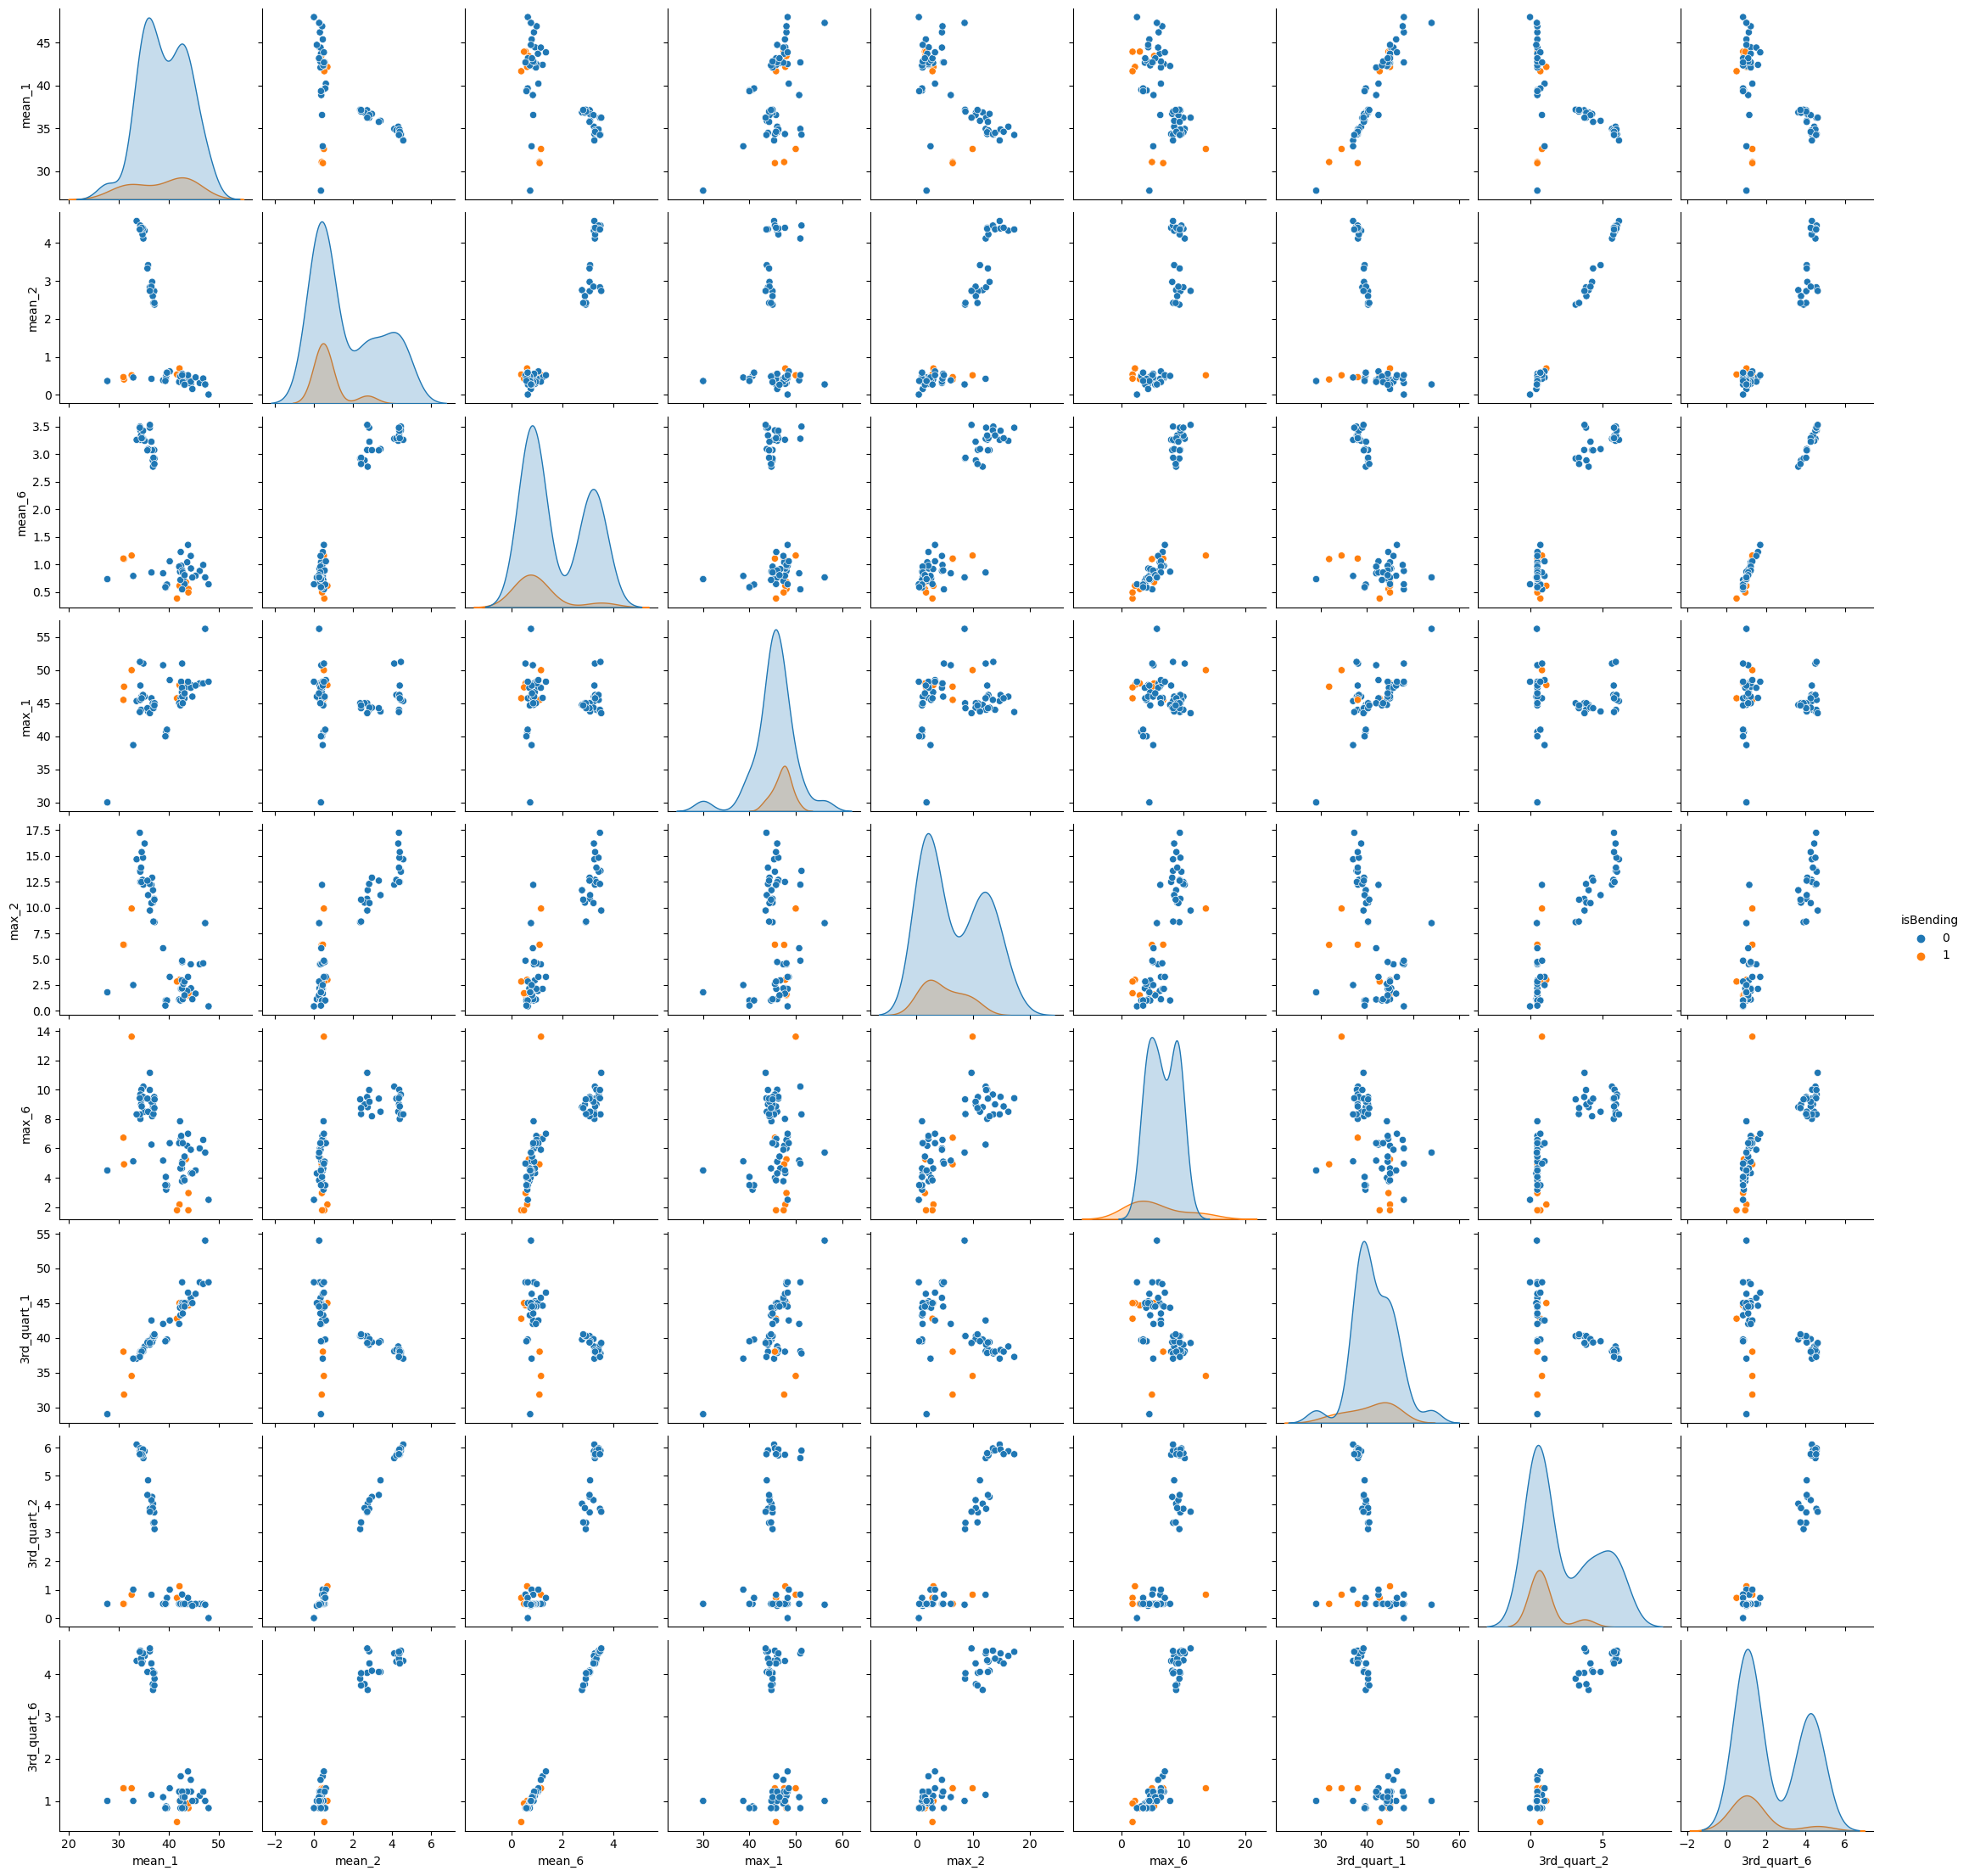

In [8]:
# Create scatter plot
sns.pairplot(bending_features, hue='isBending')

#### ii. Splitted Plots

In [9]:
def extract_split_features(df):
    features = {}
    time_series = 1
    for col in df.columns:
        temp_series = df[col]
        features[f'min_{time_series}'] = temp_series.min()
        features[f'max_{time_series}'] = temp_series.max()
        features[f'mean_{time_series}'] = temp_series.mean()
        features[f'median_{time_series}'] = temp_series.median()
        features[f'std_{time_series}'] = temp_series.std()
        features[f'1st_quart_{time_series}'] = temp_series.quantile(0.25)
        features[f'3rd_quart_{time_series}'] = temp_series.quantile(0.75)
        time_series += 1
    return features

def split_and_extract_features(instance_df, folds):
    # Calculate the length of each split
    split_length = len(instance_df) // folds
    split_series_data = {}

    for col_num, col_name in enumerate(instance_df.columns, 1):
        for fold in range(folds):
            split_series = instance_df[col_name].iloc[fold * split_length: (fold + 1) * split_length].reset_index(drop=True)
            split_series_data[f'{col_name}_{fold + 1}'] = split_series

    # Concatenate split series data and extract features
    combined = pd.DataFrame(split_series_data)
    return extract_split_features(combined)


def get_split_dataset_bending(df, folds):
    # List to hold the features from each instance
    split_features_df = []
    
    for _, group in df.groupby('instance'):
        instance_val = group['instance'].iloc[0]
        instance_features = split_and_extract_features(group.iloc[:, 1:7], folds=folds)
        # after extracting features append corresponding instance value
        instance_features['instance'] = instance_val
        split_features_df.append(instance_features)
    
    split_features_df = pd.DataFrame(split_features_df)
    split_features_df['isBending'] = split_features_df['instance'].apply(lambda x: 1 if x in bending_instances else 0)
    return split_features_df

split_features_df_2 = get_split_dataset_bending(train_df, 2)
split_features_df_2

min_1  max_1     mean_1  median_1     std_1  1st_quart_1  3rd_quart_1  \
0   36.67  45.00  43.486208     43.71  1.281976      42.3300        44.50   
1   39.00  48.00  44.117042     45.00  1.359836      43.5000        45.00   
2   33.75  47.75  43.278875     45.00  3.473355      42.0000        45.25   
3   33.00  45.75  41.621208     42.33  3.118644      39.6525        44.25   
4   36.50  46.50  44.057167     44.50  1.556971      43.2500        45.00   
..    ...    ...        ...       ...       ...          ...          ...   
64  20.00  44.25  35.692167     35.50  4.643595      33.0000        39.25   
65  24.25  45.00  36.954208     36.00  3.772836      34.2500        40.25   
66  27.00  42.67  36.342750     36.75  3.648495      33.6700        39.00   
67  26.25  43.40  36.865417     36.25  3.462793      34.3100        40.00   
68  27.75  44.00  37.144583     36.67  3.804785      34.0000        40.33   

    min_2  max_2     mean_2  ...  3rd_quart_11  min_12  max_12   mean_12  \
0   36.25  48.00  44.452042  ...        0.8300     0.0    2.96  0.585750   
1   37.00  46.50  42.792875  ...        1.1200     0.0    4.06  0.543875   
2   33.00  46.00  41.080750  ...        1.2200     0.0    2.18  0.586083   
3   39.25  43.67  41.734917  ...        0.7100     0.0    1.50  0.347500   
4   35.00  47.40  43.851833  ...        1.0000     0.0    1.50  0.388333   
..    ...    ...        ...  ...           ...     ...     ...       ...   
64  18.50  44.00  35.812542  ...        4.3500     0.0    8.81  2.966917   
65  29.00  44.67  37.399875  ...        3.9375     0.0    9.34  2.838083   
66  23.33  43.50  36.145417  ...        4.7025     0.0   11.15  3.513250   
67  29.25  44.25  37.049500  ...        4.0375     0.0    8.34  2.904458   
68  31.00  44.67  37.145083  ...        3.9000     0.0    7.93  2.730167   

    median_12    std_12  1st_quart_12  3rd_quart_12  instance  isBending  
0        0.50  0.487918        0.4225        0.8300         1          1  
1        0.50  0.473445        0.4300        0.7100         2          1  
2        0.47  0.491873        0.0000        0.8700         3          1  
3        0.43  0.363144        0.0000        0.5000         4          1  
4        0.00  0.478528        0.0000        0.7100         7          1  
..        ...       ...           ...           ...       ...        ...  
64       2.59  1.712062        1.8525        3.7400        84          0  
65       2.45  1.890755        1.3825        3.8325        85          0  
66       3.08  1.978396        2.1700        4.5000        86          0  
67       2.57  1.609793        1.6900        3.7700        87          0  
68       2.55  1.590096        1.4950        3.7050        88          0  

[69 rows x 86 columns]

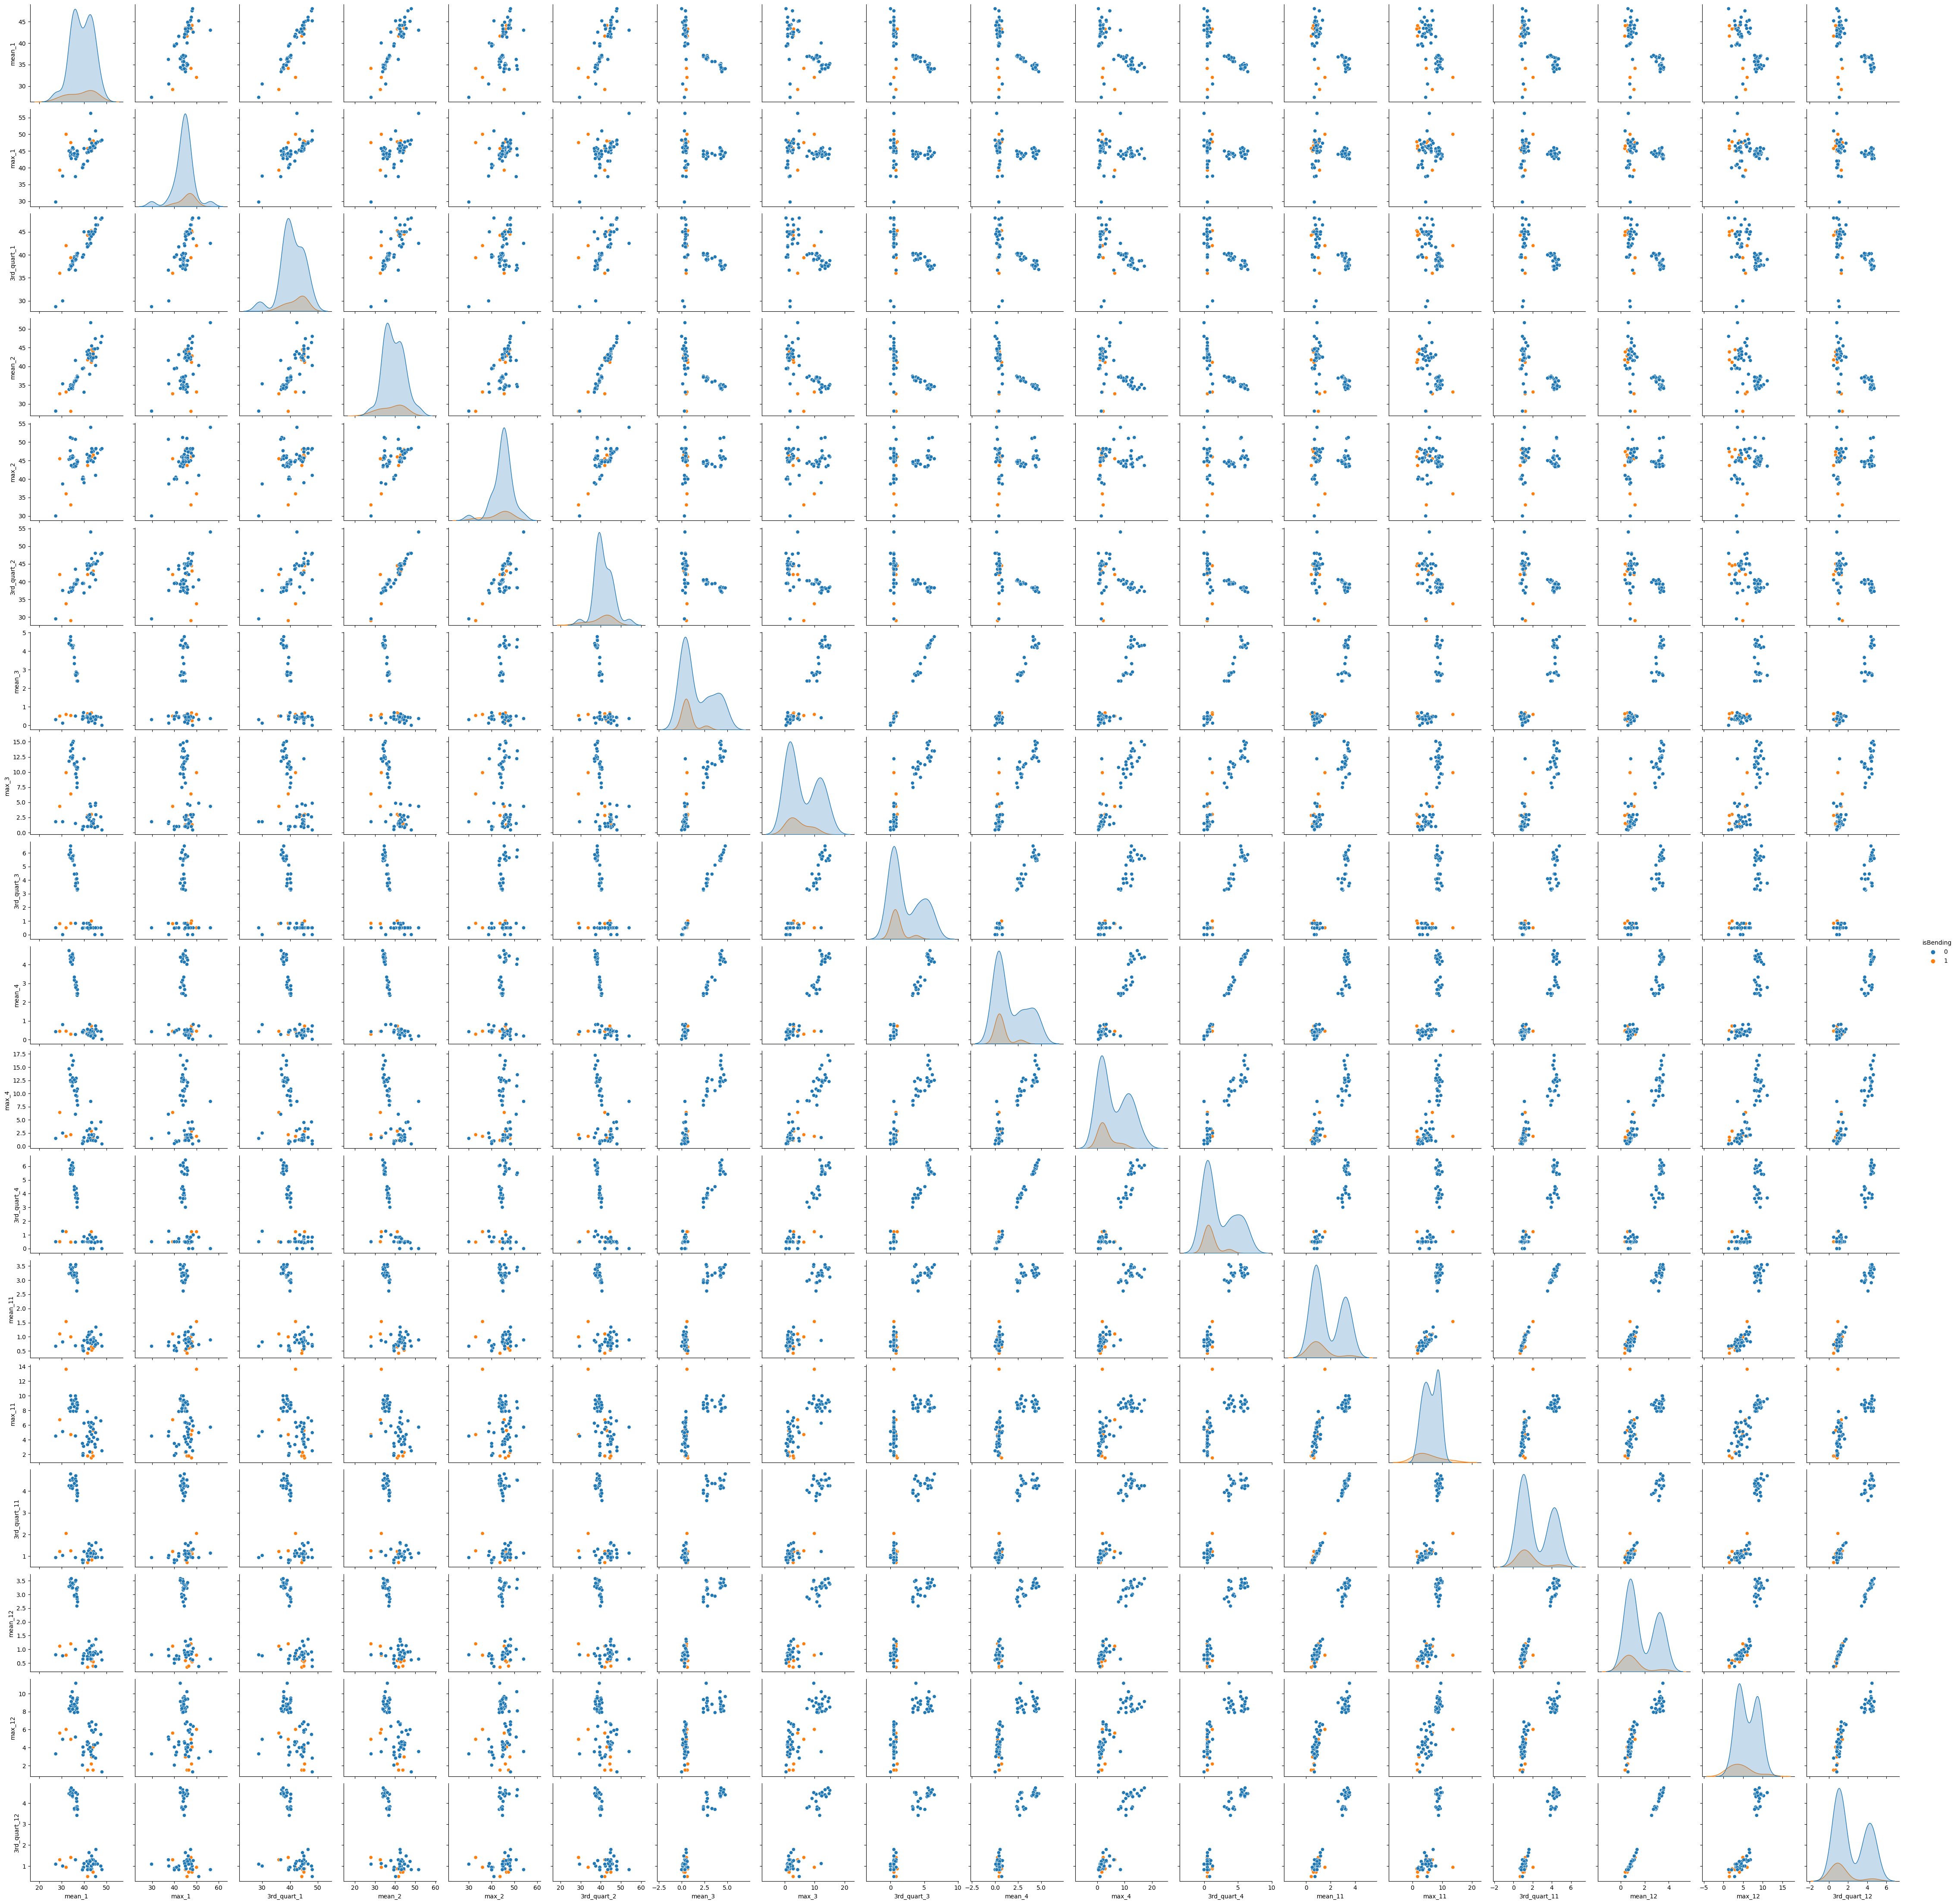

In [10]:
chosen_features = ['mean', 'max', '3rd_quart']
split_plot_cols = []

# Mapping:
# Original Time Series 1 -> Split Time Series 1, 2
# Original Time Series 2 -> Split Time Series 3, 4
# Original Time Series 6 -> Split Time Series 11, 12
for i in [1, 2, 3, 4, 11, 12]:
    for name in chosen_features:
        split_plot_cols.append(name + '_' + str(i))
split_plot_cols.append('isBending')
sns.pairplot(split_features_df_2[split_plot_cols], hue='isBending')
plt.show()

There does not seem to be a significant difference by looking at the original pair plot vs the corresponding plots in the split time series pair plot.

#### iii. Time Series Segments

In [11]:
# loop from 1 - 21 and parition the data into l folds
# fit a Logistic Regression model and print out model summary

CV_results = {} # store results of RFECV in dict

# Suppress ConvergenceWarning warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for l in range(1, 21):
        split_features_df = get_split_dataset_bending(train_df, l)
    
        y = split_features_df['isBending']
        X = split_features_df.drop(['isBending', 'instance'], axis=1)
    
        model = LogisticRegression(max_iter=100)
    
        # Use StratifiedKFold to ensure balanced class representation in each fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)
    
        # Use RFECV to find the optimal number of features 'p'
        selector = RFECV(estimator=model, step=1, cv=skf, scoring='accuracy')
        selector = selector.fit(X, y)
    
        CV_results[l] = {
            "selected_features": X.columns[selector.support_],
            "num_features": selector.n_features_,
            "mean_cv_score": np.mean(selector.cv_results_['mean_test_score']),
        }
    
        # Display information
        print(f"({l}, {selector.n_features_})")
        print(f"Cross validation score: {np.round(np.mean(selector.cv_results_['mean_test_score']), 4)}")
        print()

(1, 16)
Cross validation score: 0.9602

(2, 24)
Cross validation score: 0.9624

(3, 1)
Cross validation score: 0.9693

(4, 20)
Cross validation score: 0.9711

(5, 8)
Cross validation score: 0.9589

(6, 14)
Cross validation score: 0.9587

(7, 9)
Cross validation score: 0.9655

(8, 22)
Cross validation score: 0.971

(9, 28)
Cross validation score: 0.9517

(10, 34)
Cross validation score: 0.9492

(11, 20)
Cross validation score: 0.9519

(12, 9)
Cross validation score: 0.9566

(13, 4)
Cross validation score: 0.9645

(14, 43)
Cross validation score: 0.9508

(15, 14)
Cross validation score: 0.9497

(16, 2)
Cross validation score: 0.9528

(17, 1)
Cross validation score: 0.9569

(18, 5)
Cross validation score: 0.9484

(19, 1)
Cross validation score: 0.9489

(20, 60)
Cross validation score: 0.9484



The right way to perform cross validation is to do cross validation across all features and then use the results of the cross validation to decide on which features to prune, not to first prune the features then do cross validation on the pruned features.

#### iv. Confusion Matrix

Best l, and best p:

I am choosing (4, 20) as my best l and best p, as this has the highest average CV score.

In [12]:
best_cv_accuracy = max(val["mean_cv_score"] for val in CV_results.values())
print(f"Best CV score: {best_cv_accuracy}")
best_l = 4
print(f"Best l: {best_l}")

# Extract the best features for the best l
best_features = CV_results[best_l]["selected_features"]
print("Best features:")
print(best_features)

Best CV score: 0.9710884353741498
Best l: 4
Best features:
Index(['max_2', 'max_3', '1st_quart_3', '3rd_quart_3', 'max_5', 'min_9',
       'max_9', '1st_quart_11', 'min_12', 'max_13', 'max_14', 'min_17',
       'max_17', 'mean_17', '3rd_quart_17', 'min_18', 'max_18', 'mean_20',
       'median_20', '1st_quart_20'],
      dtype='object')


In [13]:
split_features_df = get_split_dataset_bending(train_df, best_l)

# Select best features
X_best = split_features_df[best_features]
y = split_features_df['isBending']

# Refit the logistic regression model using best features
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_best, y)

# get confusion matrix
y_pred = best_model.predict(X_best)
confusion_matrix_result = confusion_matrix(y, y_pred)
print("Confusion matrix:")
print(confusion_matrix_result)

Confusion matrix:
[[60  0]
 [ 1  8]]


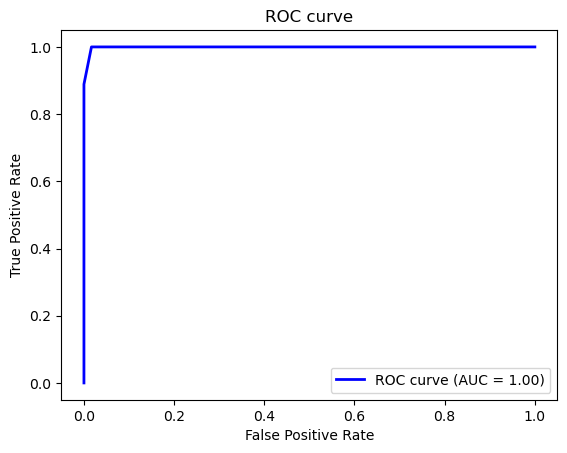

In [14]:
# Compute probabilities of the positive class
y_prob = best_model.predict_proba(X_best)[:, 1]

fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Parameters and p-values
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
    X_with_const = sm.add_constant(X_best)
    sm_model = sm.Logit(y, X_with_const).fit()

    print(sm_model.summary())

         Current function value: 0.020091
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              isBending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                           20
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                  0.9481
Time:                        23:26:01   Log-Likelihood:                -1.3863
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 0.0001779
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -90.0818   2.65e+07   -3.4e-06      1.000   -5.19e+07    5.19e+07
max_2            1.1341   2.22e+05   5.11e-06      1.000   

#### v. Test Classifier

In [16]:
# split test dataset best on the parameters established earlier from CV
split_test_df = get_split_dataset_bending(test_df, best_l)

X_test = split_test_df[best_features]
y_test = split_test_df['isBending']

y_pred = best_model.predict(X_test)


test_accuracy = accuracy_score(y_test, y_pred)

# print test accuracy vs train accuracy
print(f"Test set accuracy: {test_accuracy}")
print(f"Training cross-validation accuracy: {best_cv_accuracy}")

Test set accuracy: 1.0
Training cross-validation accuracy: 0.9710884353741498


In [17]:
# Generate and display the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print("Test data confusion matrix:")
print(confusion_matrix_result)

Test data confusion matrix:
[[15  0]
 [ 0  4]]


#### vi. Separation

Yes the classes do seem to be well seperated, the output above tells us that the the max iterations value of 35 has been exceeded, meaning the model parameters have not been able to converge on a value. The reason why this happens is that the data is linearly seperable so the coefficients for the classifier keep getting more positive or more negative and are unable to converge.

#### vii. Imbalance

Yes there are are imbalanced classes. From my confusion matrix we can see that the training set has 60 instances of the negative class and 9 instances of the positive class.

In [18]:
# loop from 1 - 21 and parition the data into l folds
CV_results_resampled = {} # store results of RFECV in dict

# Suppress ConvergenceWarning warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for l in range(1, 21):
        split_features_df = get_split_dataset_bending(train_df, l)
    
        y = split_features_df['isBending']
        X = split_features_df.drop(['isBending', 'instance'], axis=1)
    
        # Apply SMOTE to oversample positive class
        smote_model = SMOTE(random_state=42)
        X_resampled, y_resampled = smote_model.fit_resample(X, y)

        model = LogisticRegression(max_iter=100)
    
        # Use StratifiedKFold to ensure balanced class representation in each fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)
    
        # Use RFECV to find the optimal number of features 'p'
        selector = RFECV(estimator=model, step=1, cv=skf, scoring='accuracy')
        selector = selector.fit(X_resampled, y_resampled)
    
        CV_results_resampled[l] = {
            "selected_features": X.columns[selector.support_],
            "num_features": selector.n_features_,
            "mean_cv_score": np.mean(selector.cv_results_['mean_test_score']),
        }
    
        # Display information
        print(f"({l}, {selector.n_features_})")
        print(f"Cross validation score: {np.round(np.mean(selector.cv_results_['mean_test_score']), 4)}")
        print()

(1, 27)
Cross validation score: 0.9837

(2, 4)
Cross validation score: 0.9698

(3, 2)
Cross validation score: 0.9774

(4, 3)
Cross validation score: 0.9762

(5, 5)
Cross validation score: 0.9755

(6, 1)
Cross validation score: 0.976

(7, 2)
Cross validation score: 0.9754

(8, 5)
Cross validation score: 0.9698

(9, 5)
Cross validation score: 0.976

(10, 2)
Cross validation score: 0.9757

(11, 13)
Cross validation score: 0.9758

(12, 5)
Cross validation score: 0.9755

(13, 8)
Cross validation score: 0.9757

(14, 15)
Cross validation score: 0.9758

(15, 3)
Cross validation score: 0.9754

(16, 6)
Cross validation score: 0.9753

(17, 7)
Cross validation score: 0.9759

(18, 2)
Cross validation score: 0.9755

(19, 8)
Cross validation score: 0.9755

(20, 6)
Cross validation score: 0.9757



In [19]:
# Choose (1, 27) as our best l and best p
best_cv_accuracy_resampled = max(val["mean_cv_score"] for val in CV_results_resampled.values())
print(f"Best CV score: {best_cv_accuracy_resampled}")
best_l_resampled = 1
print(f"Best l: {best_l_resampled}")

# Extract the best features for the best l
best_features_resampled = CV_results_resampled[best_l_resampled]["selected_features"]
print("Best features:")
print(best_features_resampled)

Best CV score: 0.983730158730159
Best l: 1
Best features:
Index(['min_1', 'max_1', 'mean_1', 'median_1', 'std_1', '1st_quart_1',
       '3rd_quart_1', 'max_2', 'mean_2', 'median_2', '1st_quart_2',
       '3rd_quart_2', 'max_3', 'median_3', '3rd_quart_3', 'max_4', 'mean_4',
       'median_4', '1st_quart_4', '3rd_quart_4', 'min_5', 'max_5', 'mean_5',
       'median_5', '3rd_quart_5', 'max_6', '3rd_quart_6'],
      dtype='object')


In [20]:
split_features_df = get_split_dataset_bending(train_df, best_l_resampled)

# Select best features
X_best = split_features_df[best_features_resampled]
y = split_features_df['isBending']

# Apply SMOTE to upsample positive class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_best, y)

# Refit the logistic regression model using best features and the resampled data
best_model_resampled = LogisticRegression(max_iter=1000)
best_model_resampled.fit(X_resampled, y_resampled)

# get confusion matrix, predicting on the original data
y_pred = best_model_resampled.predict(X_best)
confusion_matrix_result = confusion_matrix(y, y_pred)
print("Confusion matrix:")
print(confusion_matrix_result)

Confusion matrix:
[[59  1]
 [ 0  9]]


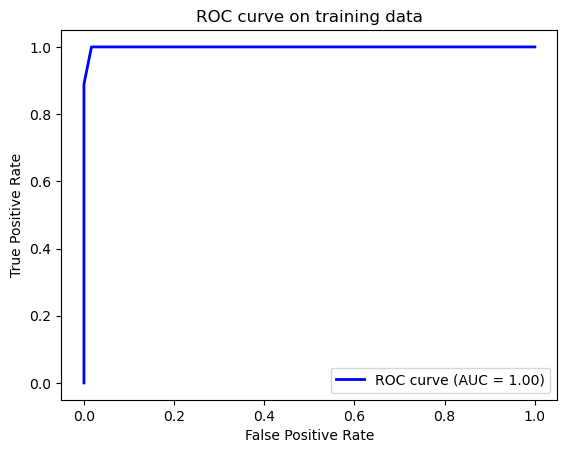

In [21]:
# Compute probabilities of the positive class
y_prob = best_model_resampled.predict_proba(X_best)[:, 1]

fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on training data')
plt.legend(loc="lower right")
plt.show()

In [22]:
split_features_df = get_split_dataset_bending(test_df, best_l_resampled)

# Select best features
X_test = split_features_df[best_features_resampled]
y = split_features_df['isBending']

# get confusion matrix, predicting on the original data
y_pred = best_model_resampled.predict(X_test)
confusion_matrix_result = confusion_matrix(y, y_pred)
print("Test data confusion matrix:")
print(confusion_matrix_result)

Test data confusion matrix:
[[15  0]
 [ 0  4]]


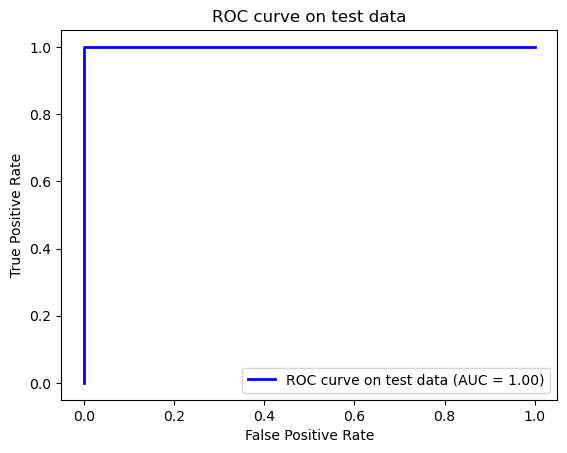

In [23]:
# Compute probabilities of the positive class
y_prob = best_model_resampled.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve on test data (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on test data')
plt.legend(loc="lower right")
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [24]:
# Initialize a storage dictionary for results
CV_results_l1 = {}

# Loop over l
for l in range(1, 21):
    split_features_df = get_split_dataset_bending(train_df, l)

    y = split_features_df['isBending']
    X = split_features_df.drop(['isBending', 'instance'], axis=1)

    # Apply SMOTE to upsample positive class
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # L1-penalized logistic regression with cross-validation
    model_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, max_iter=100)
    model_l1.fit(X_resampled, y_resampled)

    # Identify the selected features
    coef = model_l1.coef_[0]
    selected_features = X.columns[coef != 0].tolist()
    
    # Score the model on the training set
    accuracy = model_l1.score(X, y)

    # Store results in the dictionary
    CV_results_l1[l] = {
        "selected_features": selected_features,
        "num_features": len(selected_features),
        "train_score": accuracy,
        "optimal_C": model_l1.C_[0]
    }

    # Display information
    print(f"{l, len(selected_features)}:")
    print(f"Training accuracy: {accuracy:.4f}")
    print(f"Optimal C (1/lambda) value: {model_l1.C_[0]}")
    print()

(1, 7):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.3593813663804626

(2, 7):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.3593813663804626

(3, 36):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 21.54434690031882

(4, 9):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.046415888336127774

(5, 8):
Training accuracy: 0.9710
Optimal C (1/lambda) value: 0.046415888336127774

(6, 11):
Training accuracy: 0.9710
Optimal C (1/lambda) value: 0.046415888336127774

(7, 9):
Training accuracy: 0.9710
Optimal C (1/lambda) value: 0.046415888336127774

(8, 9):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.046415888336127774

(9, 7):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.046415888336127774

(10, 7):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.046415888336127774

(11, 8):
Training accuracy: 0.9710
Optimal C (1/lambda) value: 0.046415888336127774

(12, 6):
Training accuracy: 0.9855
Optimal C (1/lambda) value: 0.04641588833612

In [25]:
# Choose (1, 7) as our best (l, p)
best_l_l1 = 1

# Extract the results for the best l from CV_results_l1
best_C_l1 = CV_results_l1[best_l_l1]["optimal_C"]
best_features_l1 = CV_results_l1[best_l_l1]["selected_features"]
best_train_score_l1 = CV_results_l1[best_l_l1]["train_score"]

print(f"Best l: {best_l_l1}")
print(f"Optimal C (1/lambda) value: {best_C_l1}")
print(f"Training accuracy: {best_train_score_l1:.4f}")
print("Selected features:")
print(best_features_l1)

Best l: 1
Optimal C (1/lambda) value: 0.3593813663804626
Training accuracy: 0.9855
Selected features:
['min_1', 'max_1', '3rd_quart_1', 'max_2', 'min_5', 'max_5', '1st_quart_5']


In [26]:
split_features_df = get_split_dataset_bending(train_df, best_l_l1)

# Select best features
X_best = split_features_df[best_features_l1]  # Using best_features_l1 which is obtained from L1-penalized model
y = split_features_df['isBending']

# Apply SMOTE to upsample positive class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_best, y)

# Refit the logistic regression model using best features and the resampled data, 
best_model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=best_C_l1, max_iter=100)  # Using best_C_l1
best_model_l1.fit(X_resampled, y_resampled)

# Get confusion matrix, predicting on the resampled data
y_pred = best_model_l1.predict(X_best)
confusion_matrix_result = confusion_matrix(y, y_pred)
print("Confusion matrix on training data:")
print(confusion_matrix_result)

Confusion matrix on training data:
[[59  1]
 [ 0  9]]


In [27]:
split_features_df = get_split_dataset_bending(test_df, best_l_l1)

# Select best features
X_test = split_features_df[best_features_l1]
y_test = split_features_df['isBending']

y_pred = best_model_l1.predict(X_test)

# print test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 1.0


In [28]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print("Test data confusion matrix:")
print(confusion_matrix_result)

Test data confusion matrix:
[[15  0]
 [ 0  4]]


#### ii. Comparison

The L1 regularized model performs the best.

It has the highest training accuracy of the three, and the testing accuracy is 1.0 across the board for all three as well. On top of this model is easier to implement than using variable selection with p values as it performs feature selection automatically, and runs the fastest out of the three.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [29]:
def get_split_dataset_multi(df, folds):
    split_features_df = []
    
    for _, group in df.groupby('instance'):
        instance_val = group['instance'].iloc[0]
        
        # Extract features and append the corresponding instance value
        instance_features = split_and_extract_features(group.iloc[:, 1:7], folds=folds)
        instance_features['instance'] = instance_val
        
        # Retrieve folder_name and print it along with instance_val for debugging
        folder_name = group['folder'].iloc[0]
        class_label = folder_name.split('/')[0]
        
        # Add class label to the features
        instance_features['class'] = class_label
        split_features_df.append(instance_features)
        
    split_features_df = pd.DataFrame(split_features_df)
    return split_features_df

In [30]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    CV_results_multi = {}
    # Loop over l from 1 to 20
    for l in range(1, 21):
    
        # Using multiple classes
        split_features_df = get_split_dataset_multi(train_df, l)
    
        y = split_features_df['class']
        X = split_features_df.drop(['class', 'instance'], axis=1)
        
        # L1-penalized logistic regression with cross-validation - multiclass
        model_l1_multi = LogisticRegressionCV(penalty='l1', solver='saga', cv=StratifiedKFold(n_splits=5), 
                                        max_iter=1000, multi_class='multinomial')
        model_l1_multi.fit(X, y)
    
        # Identify the selected features
        # In the multi-class case, coefs_ will have shape (n_classes, n_features)
        # Below logic extracts features that are non-zero in any class
        coef = model_l1_multi.coef_
        selected_features = X.columns[(coef != 0).any(axis=0)].tolist()
        
        # Score the model on the training set
        accuracy = model_l1_multi.score(X, y)
    
        # Store results in the dictionary
        CV_results_multi[l] = {
            "selected_features": selected_features,
            "num_features": len(selected_features),
            "train_score": accuracy,
            "optimal_C": model_l1.C_  # best C for each class after cross-validation
        }
    
        # Display information
        print(f"{l, len(selected_features)}:")
        print(f"Training accuracy: {accuracy:.4f}")
        print(f"Optimal C (1/lambda) values: {model_l1_multi.C_}")
        print()

(1, 34):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594]

(2, 80):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [21.5443469 21.5443469 21.5443469 21.5443469 21.5443469 21.5443469
 21.5443469]

(3, 120):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [21.5443469 21.5443469 21.5443469 21.5443469 21.5443469 21.5443469
 21.5443469]

(4, 131):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594]

(5, 155):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594]

(6, 118):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137
 0.35938137]

(7, 225):
Training accuracy: 0.9855
Optimal C (1/lambda) values: [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594]

(8, 259):
Tr

In [31]:
# Choose 1 as our best l as we have the same training accuracy across the board and this model is simpler
best_l_multi = 1
best_num_features = CV_results_multi[best_l_multi]["num_features"]

# Extracting information for l=3
best_features_multi = CV_results_multi[best_l_multi]["selected_features"]
best_C_multi = CV_results_multi[best_l_multi]["optimal_C"]
best_cv_accuracy_multi = CV_results_multi[best_l_multi]["train_score"]

# Displaying the retrieved information
print(f"Best l,  best p: ({best_l_multi}, {best_num_features}) \n")
print("Best features:")
print(best_features_multi)
print(f"\nBest CV score: {best_cv_accuracy_multi:.4f}")

Best l,  best p: (1, 34) 

Best features:
['min_1', 'max_1', 'mean_1', 'median_1', 'std_1', '1st_quart_1', '3rd_quart_1', 'max_2', 'mean_2', 'median_2', '1st_quart_2', '3rd_quart_2', 'min_3', 'max_3', 'mean_3', 'median_3', 'std_3', '1st_quart_3', '3rd_quart_3', 'max_4', 'mean_4', 'median_4', '1st_quart_4', '3rd_quart_4', 'min_5', 'max_5', 'mean_5', 'median_5', 'std_5', '1st_quart_5', '3rd_quart_5', 'max_6', 'mean_6', '3rd_quart_6']

Best CV score: 0.9855


In [32]:
split_features_df = get_split_dataset_multi(train_df, best_l_multi)

# Select best features
X_best = split_features_df[best_features_multi]
y = split_features_df['class']

# Refit the logistic regression model using best features and the resampled data
best_model_l1_multi = LogisticRegression(penalty='l1', solver='saga', C=best_C_l1, max_iter=10000, multi_class='multinomial')  # Using best_C_l1
best_model_l1_multi.fit(X_best, y)

# Get confusion matrix, predicting on the original data
y_pred = best_model_l1_multi.predict(X_best)
confusion_matrix_result = confusion_matrix(y, y_pred)
print("Confusion matrix on training data:")
print(confusion_matrix_result)

Confusion matrix on training data:
[[ 5  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


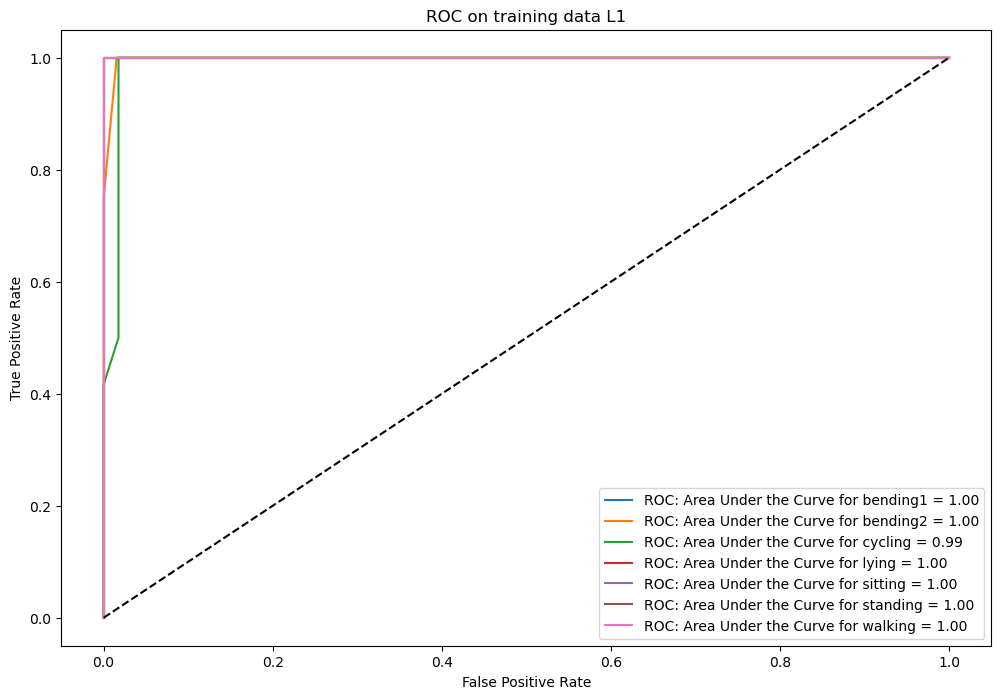

In [33]:
# Assuming best_model_l1_multi is your trained model and X_best and y are your data.
prediction_probabilities = best_model_l1_multi.predict_proba(X_best)

fig, ax = plt.subplots(figsize=(12, 8))

# Enumerating through class labels and their corresponding probability predictions
for i, label in enumerate(best_model_l1_multi.classes_):
    fpr, tpr, _ = roc_curve(y == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.2f}")

# Plotting a random (dashed) line
ax.plot([0, 1], [0, 1], 'k--')

# Labeling the axes and titling the plot
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC on training data L1")
ax.legend(loc='best')

# Displaying the plot
plt.show()

In [34]:
split_features_df_multi = get_split_dataset_multi(test_df, best_l_multi)

# Select best features
X_test_multi = split_features_df_multi[best_features_multi]
y_test_multi = split_features_df_multi['class']

# Assuming model_l1 is your trained model using best_l_multi and best_features_multi
y_pred_multi = best_model_l1_multi.predict(X_test_multi)

# Print test accuracy
test_accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)
print(f"Multiclass test error: {1 - test_accuracy_multi:.4f}")

Multiclass test error: 0.1053


In [35]:
# Get confusion matrix, predicting on the original data
confusion_matrix_result = confusion_matrix(y_test_multi, y_pred_multi)
print("Confusion matrix on test data:")
print(confusion_matrix_result)

Confusion matrix on test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 1]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


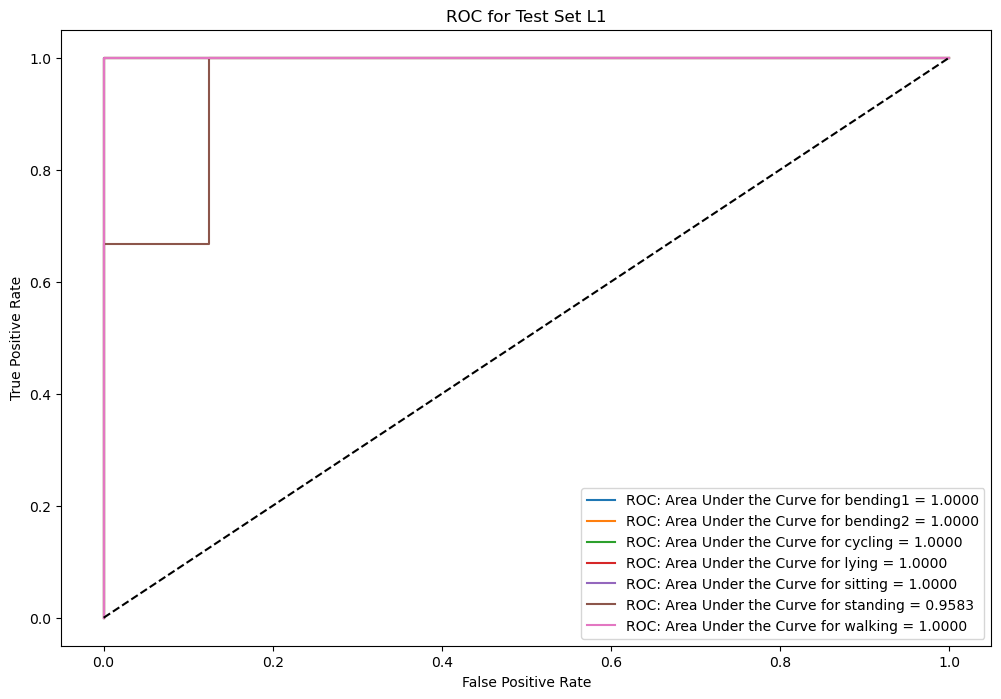

In [36]:
# Predict probabilities
prediction_probabilities = best_model_l1_multi.predict_proba(X_test_multi)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(12, 8))

for i, label in enumerate(best_model_l1_multi.classes_):
    fpr, tpr, _ = roc_curve(y_test_multi == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.4f}")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC for Test Set L1")
ax.legend(loc='best')
plt.show()

#### ii. Naive Bayes

In [37]:
# Initialize a storage dictionary for results
GNB_results_multi = {}
    
# Loop over l from 1 to 20
for l in range(1, 21):

    # Using multiple classes
    split_features_df = get_split_dataset_multi(train_df, l)

    y = split_features_df['class']
    X = split_features_df.drop(['class', 'instance'], axis=1)
    
    # Gaussian Naive Bayes classifier
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(X, y)
    gaussian_train_score = gaussian_nb.score(X, y) 
    
    # Store results in the dictionary
    GNB_results_multi[l] = {
        "gaussian_train_score": gaussian_train_score,
    }
    
    # Display information
    print(f"l = {l}:")
    print(f"GaussianNB Training Accuracy: {gaussian_train_score:.4f}")
    print()

l = 1:
GaussianNB Training Accuracy: 0.9855

l = 2:
GaussianNB Training Accuracy: 0.9855

l = 3:
GaussianNB Training Accuracy: 0.9710

l = 4:
GaussianNB Training Accuracy: 0.9855

l = 5:
GaussianNB Training Accuracy: 0.9710

l = 6:
GaussianNB Training Accuracy: 0.9565

l = 7:
GaussianNB Training Accuracy: 0.9855

l = 8:
GaussianNB Training Accuracy: 0.9710

l = 9:
GaussianNB Training Accuracy: 0.9855

l = 10:
GaussianNB Training Accuracy: 0.9855

l = 11:
GaussianNB Training Accuracy: 0.9710

l = 12:
GaussianNB Training Accuracy: 0.9855

l = 13:
GaussianNB Training Accuracy: 0.9855

l = 14:
GaussianNB Training Accuracy: 0.9855

l = 15:
GaussianNB Training Accuracy: 0.9855

l = 16:
GaussianNB Training Accuracy: 0.9855

l = 17:
GaussianNB Training Accuracy: 0.9855

l = 18:
GaussianNB Training Accuracy: 0.9855

l = 19:
GaussianNB Training Accuracy: 0.9855

l = 20:
GaussianNB Training Accuracy: 0.9855



In [38]:
best_l_GNB = 1

gaussian_train_score = GNB_results_multi[best_l_GNB]["gaussian_train_score"]

# Display the retrieved information
print(f"Best l: {best_l_GNB}\n")
print(f"Best GaussianNB Training Accuracy: {gaussian_train_score:.4f}")

Best l: 1

Best GaussianNB Training Accuracy: 0.9855


In [39]:
# Example using the selected 'l' and the features
split_features_df = get_split_dataset_multi(train_df, best_l_GNB)

# Use all features as NB doesn't perform inherent feature selection
X = split_features_df.drop(['class', 'instance'], axis=1)
y = split_features_df['class']

# Gaussian Naive Bayes classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(X, y)

# Predicting on the training data and getting the confusion matrix
y_pred_gaussian = gaussian_nb.predict(X)
confusion_matrix_gaussian = confusion_matrix(y, y_pred_gaussian)

print("\nConfusion matrix on training data (GaussianNB):")
print(confusion_matrix_gaussian)


Confusion matrix on training data (GaussianNB):
[[ 5  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


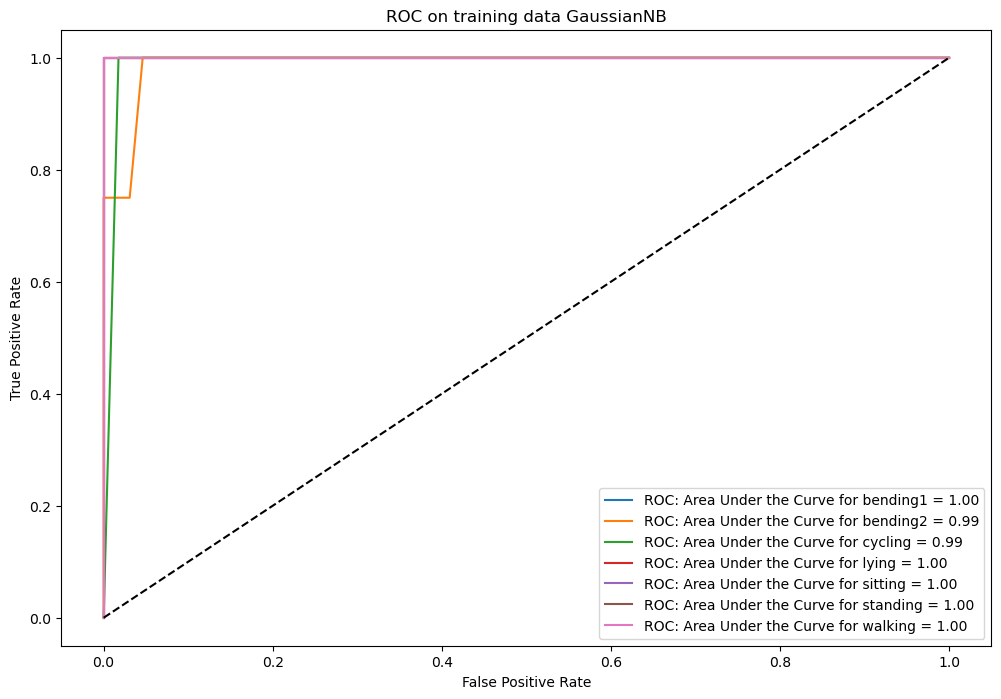

In [40]:
# Predicting probability for each class
prediction_probabilities = gaussian_nb.predict_proba(X)

fig, ax = plt.subplots(figsize=(12, 8))

# Enumerating through class labels and their corresponding probability predictions
for i, label in enumerate(gaussian_nb.classes_):
    fpr, tpr, _ = roc_curve(y == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.2f}")

# Plotting a random (dashed) line
ax.plot([0, 1], [0, 1], 'k--')

# Labeling the axes and titling the plot
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC on training data GaussianNB")
ax.legend(loc='best')

# Displaying the plot
plt.show()

In [41]:
# Example using the selected 'l' and the features
split_features_df = get_split_dataset_multi(test_df, best_l_GNB)

# Use all features as NB doesn't perform inherent feature selection
X_test_gauss = split_features_df.drop(['class', 'instance'], axis=1)
y_test_gauss = split_features_df['class']

# Predicting on the training data and getting the confusion matrix
y_pred_gaussian = gaussian_nb.predict(X_test_gauss)
confusion_matrix_gaussian = confusion_matrix(y_test_gauss, y_pred_gaussian)

print("\nConfusion matrix on test data (GaussianNB):")
print(confusion_matrix_gaussian)


Confusion matrix on test data (GaussianNB):
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


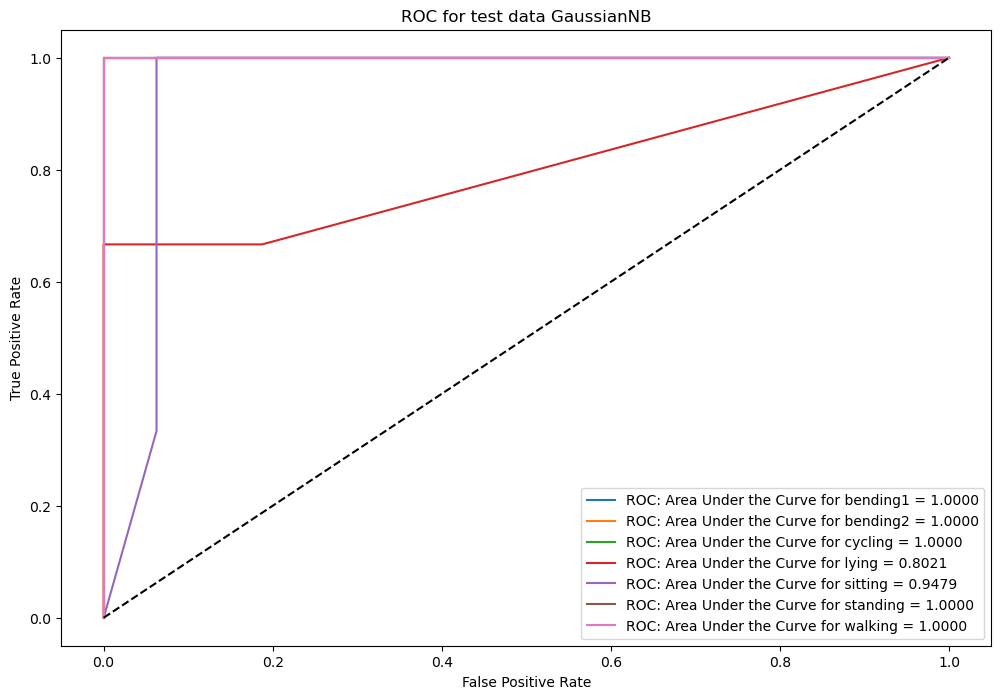

In [42]:
# Predict probabilities
prediction_probabilities = gaussian_nb.predict_proba(X_test_gauss)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(12, 8))

for i, label in enumerate(gaussian_nb.classes_):
    fpr, tpr, _ = roc_curve(y_test_multi == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.4f}")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC for test data GaussianNB")
ax.legend(loc='best')
plt.show()

In [43]:
# Initialize a storage dictionary for results
MNB_results_multi = {}
    
# Loop over l from 1 to 20
for l in range(1, 21):

    # Using multiple classes
    split_features_df = get_split_dataset_multi(train_df, l)

    y = split_features_df['class']
    X = split_features_df.drop(['class', 'instance'], axis=1)
    
    # Multinomial Naive Bayes classifier
    multinomial_nb = MultinomialNB()
    multinomial_nb.fit(X, y)
    multinomial_train_score = multinomial_nb.score(X, y)
    
    # Store results in the dictionary
    MNB_results_multi[l] = {
        "multinomial_train_score": multinomial_train_score,
    }
    
    # Display information
    print(f"l = {l}:")
    print(f"MultinomialNB Training Accuracy: {multinomial_train_score:.4f}")
    print()

l = 1:
MultinomialNB Training Accuracy: 0.9275

l = 2:
MultinomialNB Training Accuracy: 0.8841

l = 3:
MultinomialNB Training Accuracy: 0.9130

l = 4:
MultinomialNB Training Accuracy: 0.9130

l = 5:
MultinomialNB Training Accuracy: 0.9275

l = 6:
MultinomialNB Training Accuracy: 0.9565

l = 7:
MultinomialNB Training Accuracy: 0.9420

l = 8:
MultinomialNB Training Accuracy: 0.9420

l = 9:
MultinomialNB Training Accuracy: 0.9420

l = 10:
MultinomialNB Training Accuracy: 0.9420

l = 11:
MultinomialNB Training Accuracy: 0.9420

l = 12:
MultinomialNB Training Accuracy: 0.9420

l = 13:
MultinomialNB Training Accuracy: 0.9420

l = 14:
MultinomialNB Training Accuracy: 0.9420

l = 15:
MultinomialNB Training Accuracy: 0.9420

l = 16:
MultinomialNB Training Accuracy: 0.9420

l = 17:
MultinomialNB Training Accuracy: 0.9420

l = 18:
MultinomialNB Training Accuracy: 0.9420

l = 19:
MultinomialNB Training Accuracy: 0.9420

l = 20:
MultinomialNB Training Accuracy: 0.9420



In [44]:
best_l_MNB = 6

multinomial_train_score = MNB_results_multi[best_l_MNB]["multinomial_train_score"]

# Display the retrieved information
print(f"Best l: {best_l_MNB}\n")
print(f"Best GaussianNB Training Accuracy: {multinomial_train_score:.4f}")

Best l: 6

Best GaussianNB Training Accuracy: 0.9565


In [45]:
# Example using the selected 'l' and the features
split_features_df = get_split_dataset_multi(train_df, best_l_MNB)

# Use all features as NB doesn't perform inherent feature selection
X = split_features_df.drop(['class', 'instance'], axis=1)
y = split_features_df['class']

# Multinomial Naive Bayes Classifier
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X, y)

# Predicting on the training data and getting the confusion matrix
y_pred_multinomial = multinomial_nb.predict(X)
confusion_matrix_multinomial = confusion_matrix(y, y_pred_multinomial)

print("\nConfusion matrix on training data (MultinomialNB):")
print(confusion_matrix_multinomial)


Confusion matrix on training data (MultinomialNB):
[[ 5  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


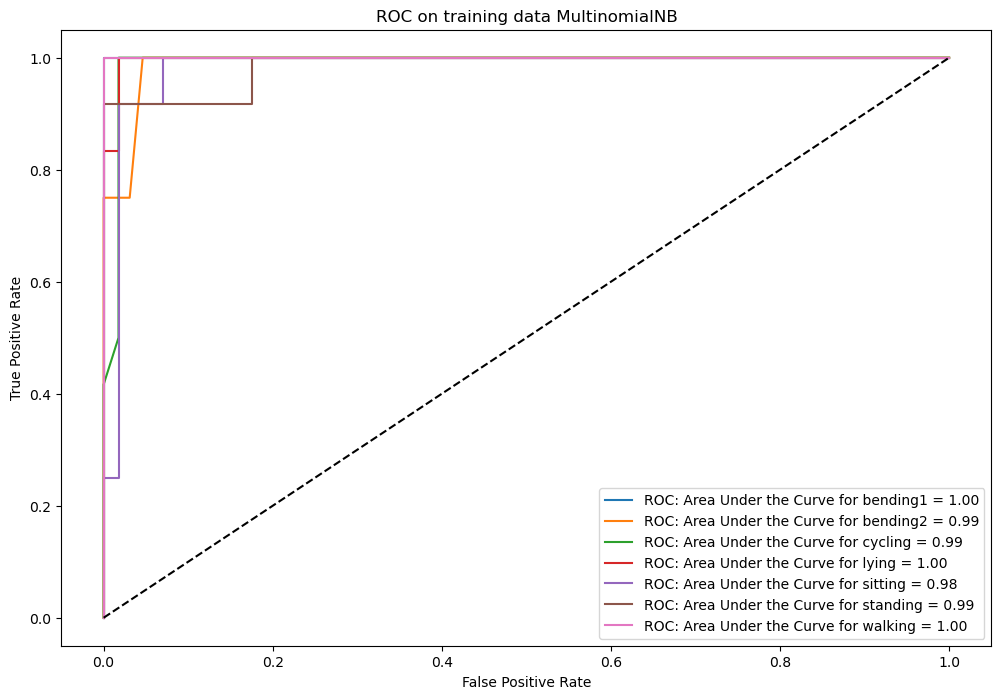

In [46]:
# Predicting probability for each class
prediction_probabilities = multinomial_nb.predict_proba(X)

fig, ax = plt.subplots(figsize=(12, 8))

# Enumerating through class labels and their corresponding probability predictions
for i, label in enumerate(multinomial_nb.classes_):
    fpr, tpr, _ = roc_curve(y == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.2f}")

# Plotting a random (dashed) line
ax.plot([0, 1], [0, 1], 'k--')

# Labeling the axes and titling the plot
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC on training data MultinomialNB")
ax.legend(loc='best')

# Displaying the plot
plt.show()

In [47]:
# Example using the selected 'l' and the features
split_features_df = get_split_dataset_multi(test_df, best_l_MNB)

# Use all features as NB doesn't perform inherent feature selection
X_test_multinomial = split_features_df.drop(['class', 'instance'], axis=1)
y_test_multinomial = split_features_df['class']

# Predicting on the training data and getting the confusion matrix
y_pred_multinomial = multinomial_nb.predict(X_test_multinomial)
confusion_matrix_multinomial = confusion_matrix(y_test_multinomial, y_pred_multinomial)

print("\nConfusion matrix on test data (MultinomialNB):")
print(confusion_matrix_multinomial)


Confusion matrix on test data (MultinomialNB):
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]


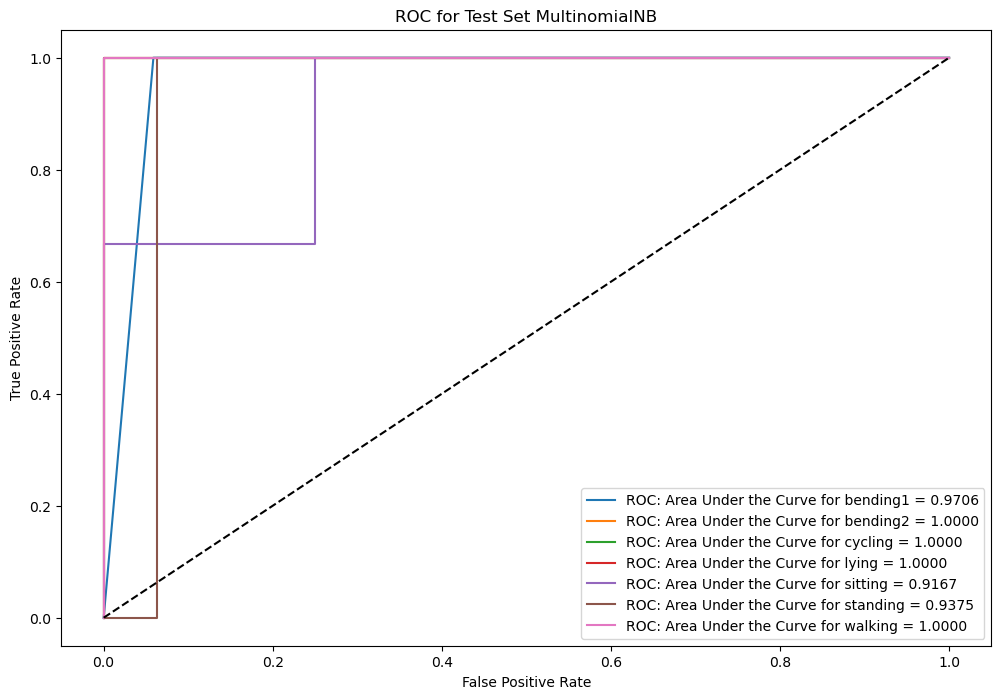

In [48]:
# Predict probabilities
prediction_probabilities = multinomial_nb.predict_proba(X_test_multinomial)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(12, 8))

for i, label in enumerate(multinomial_nb.classes_):
    fpr, tpr, _ = roc_curve(y_test_multi == label, prediction_probabilities[:, i])
    ax.plot(fpr, tpr, label=f"ROC: Area Under the Curve for {label} = {auc(fpr, tpr):.4f}")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC for Test Set MultinomialNB")
ax.legend(loc='best')
plt.show()

#### ii. Comparison

Based on the confusion matrices on the test data - we can see that the best performers are the L1 regularized and the Naive Bayes classifier with Gaussian priors, with two missclassifications as opposed to three from the Naive Bayes classifier with Multinomial priors.

Based on the ROC curves on the testing data, the L1 penalized multinomial regression model performs the best for multi-class classification. This method also has the advantage of performing feature selection as part of the training process which helps in creating a less complex model that is less prone to overfitting. We can also see that we this model does not underfit compared to the others from the training ROC curve.